In [ ]:
!pip install keras==2.15.0
!pip install pycocoevalcap

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 22.1 MB/s eta 0:00:0000:0100:01
  Attempting uninstall: keras
    Found existing installation: keras 3.3.3
    Uninstalling keras-3.3.3:
      Successfully uninstalled keras-3.3.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow-decision-forests 1.8.1 requires wurlitzer, which is not installed.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 104.3/104.3 MB 16.6 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 427.8/427.8 kB 22.4 MB/s eta 0:00:00


In [ ]:
!nvidia-smi

Thu Mar 27 05:18:22 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 560.35.03              Driver Version: 560.35.03      CUDA Version: 12.6     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   38C    P8              9W /   70W |       1MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [ ]:
import os
import re
import numpy as np
import cv2
from tqdm import tqdm
import seaborn as sns
from glob import glob
from collections import Counter
import matplotlib.pyplot as plt
from itertools import islice, cycle
from concurrent.futures import ThreadPoolExecutor, as_completed
import multiprocessing
cpu_count = multiprocessing.cpu_count()
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow.keras.applications as pretrained
from tensorflow.keras.layers import TextVectorization
from sklearn.feature_extraction.text import CountVectorizer
from scipy.spatial.distance import cosine
from pycocoevalcap.cider.cider import Cider
from IPython.display import HTML, display
from base64 import b64encode

# seed = 111
# np.random.seed(seed)
# tf.random.set_seed(seed)

2025-03-27 05:18:27.114687: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-03-27 05:18:27.114818: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-03-27 05:18:27.355751: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [ ]:
os.environ["KERAS_BACKEND"] = "tensorflow"
strategy = tf.distribute.MirroredStrategy()
print('Number of devices: {}'.format(strategy.num_replicas_in_sync))

Number of devices: 2


In [ ]:
# Path to the videos
VIDEOS_PATH = "/kaggle/input/videodata/YouTubeClips/YouTubeClips"
CAPTIONS_PATH = "/kaggle/input/videodata/MSVD-indonesian.txt"
FRAMES_STORAGE_PATH = "/kaggle/working/extracted_frames"

# Desired image dimensions
IMAGE_SIZE = (224, 224)

MAX_FRAMES = 16

NUM_CAPTIONS = 40

PATCH_SIZE = (16, 16, 16)
NUM_PATCH = int((MAX_FRAMES*(IMAGE_SIZE[0])**2) / (PATCH_SIZE[0]*PATCH_SIZE[1]**2))

# Vocabulary size
VOCAB_SIZE = 10000

# Fixed length allowed for any sequence
SEQ_LENGTH = 40

# Dimension for embeddings
EMBED_DIM = 512

NUM_HEADS = 8

# Dimension for models
D_MODELS = int(EMBED_DIM / NUM_HEADS)

# Other training parameters
BATCH_SIZE = 16
EPOCHS = 100
AUTOTUNE = tf.data.AUTOTUNE

In [ ]:
exs = (".mp4", ".avi", ".mov", ".mkv", ".wmv", ".flv", ".webm", ".mpeg", ".mpg", ".3gp")

# Load captions data
def load_captions_data(filename):
    """Loads captions (text) data and maps them to corresponding videos."""
    with open(filename) as caption_file:
        caption_data = caption_file.readlines()
        caption_mapping = {}
        text_data = []
        videos_to_skip = set()

        for line in caption_data:
            line = line.rstrip("\n")
            parts = line.split(" ", 1)
            if len(parts) < 1:
                continue
            video_name, caption = parts
            caption = caption.strip()

            # Skip empty captions
            if not caption or caption == 0:
                continue

            tokens = caption.split()
            if len(tokens) < 1 or len(tokens) > SEQ_LENGTH:
                videos_to_skip.add(video_name)
                continue

            video_name = os.path.join(VIDEOS_PATH, video_name.strip() + '.avi')

            if video_name.endswith(exs) and video_name not in videos_to_skip:
                caption = "<start> " + caption + " <end>"
                text_data.append(caption)

                if video_name in caption_mapping:
                    caption_mapping[video_name].append(caption)
                else:
                    caption_mapping[video_name] = [caption]

        for video_name in videos_to_skip:
            if video_name in caption_mapping:
                del caption_mapping[video_name]

        return caption_mapping, text_data

# Split data into training and validation sets
def train_val_split(caption_data, train_size=0.8, shuffle=False):
    all_videos = list(caption_data.keys())
    if shuffle:
        np.random.shuffle(all_videos)
    train_size = int(len(caption_data) * train_size)
    training_data = {
        video_name: caption_data[video_name] for video_name in all_videos[:train_size]
    }
    validation_data = {
        video_name: caption_data[video_name] for video_name in all_videos[train_size:]
    }
    return training_data, validation_data

# Load the dataset
captions_mapping, text_data = load_captions_data(CAPTIONS_PATH)

# Split the dataset into training and validation sets
train_data, valid_data = train_val_split(captions_mapping)
print("Number of training samples: ", len(train_data))
print("Number of validation samples: ", len(valid_data))
print(f"Unique word count: {len(set(' '.join(text_data).split()))}")

Number of training samples:  1576
Number of validation samples:  394
Unique word count: 9452


min length: 3
max length: 40


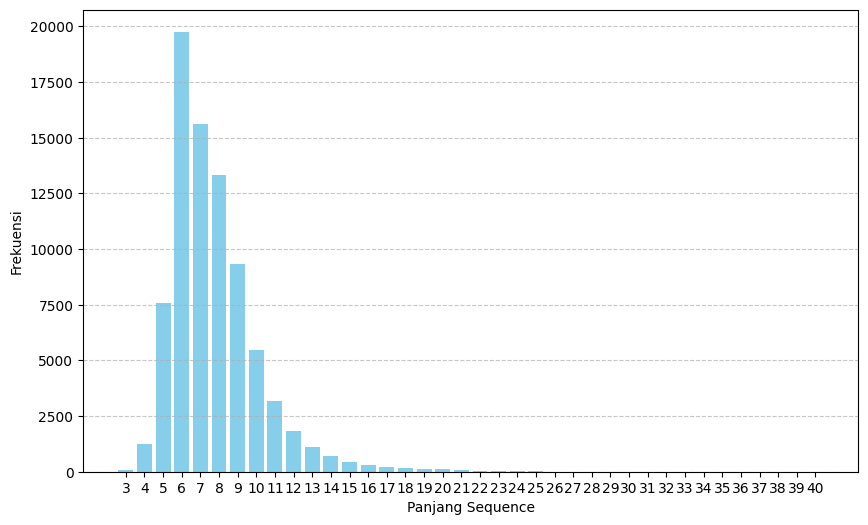

In [ ]:
lengths = [len(sentence.split()) for sentence in text_data]
length_counts = Counter(lengths)

lengths_unique = list(length_counts.keys())
frequencies = list(length_counts.values())

print("min length:", min(lengths_unique))
print("max length:", max(lengths_unique))

# Visualisasikan dengan bar plot
plt.figure(figsize=(10, 6))
plt.bar(lengths_unique, frequencies, color='skyblue')
plt.xlabel('Panjang Sequence')
plt.ylabel('Frekuensi')
plt.xticks(np.arange(min(lengths_unique), max(lengths_unique) + 1, 1))
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

Minimum number of captions: 18
Maximum number of captions: 81


/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


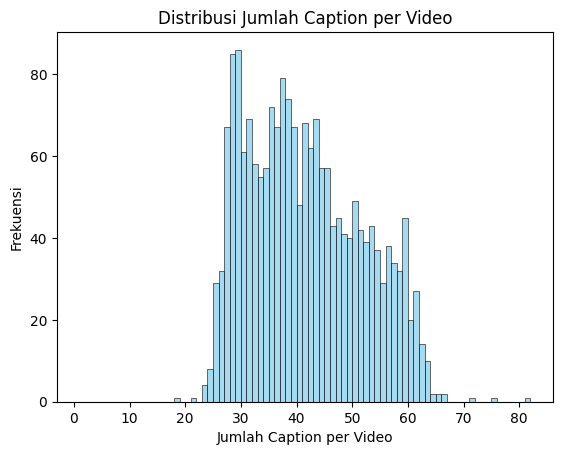

In [ ]:
merge = {**train_data, **valid_data}
num_caption = [len(captions) for captions in merge.values()]

min_caption = min(num_caption)
max_caption = max(num_caption)

print(f"Minimum number of captions: {min_caption}")
print(f"Maximum number of captions: {max_caption}")

sns.histplot(num_caption, bins=range(1, max(num_caption) + 2), color='skyblue', kde=False)
plt.xlabel('Jumlah Caption per Video')
plt.ylabel('Frekuensi')
plt.title('Distribusi Jumlah Caption per Video')
plt.show()

In [ ]:
def custom_standardization(input_string):
    return tf.strings.lower(input_string)

vectorization = TextVectorization(
    max_tokens=VOCAB_SIZE,
    output_mode="int",
    output_sequence_length=SEQ_LENGTH,
    standardize=custom_standardization,
)
vectorization.adapt(text_data)

# vocab = vectorization.get_vocabulary()
# MASK_TOKEN = "[MASK]"
# vocab = vocab + [MASK_TOKEN]
# MASK_TOKEN_ID = len(vocab) - 1
# inverse_vocab = {word: idx for idx, word in enumerate(vocab)}
# vectorization.set_vocabulary(vocab)

In [ ]:
def save_video_frames(video_path, output_dir, size=IMAGE_SIZE, max_frames=MAX_FRAMES):
    cap = cv2.VideoCapture(video_path)
    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    os.makedirs(output_dir, exist_ok=True)
    if total_frames <= max_frames:
        selected_frames = list(range(total_frames))
    else:
        selected_frames = np.linspace(0, total_frames - 1, max_frames, dtype=int)

    for idx, frame_idx in enumerate(selected_frames):
        cap.set(cv2.CAP_PROP_POS_FRAMES, frame_idx)
        ret, frame = cap.read()
        if not ret:
            break

        frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
#         frame = cv2.resize(frame, size)
        frame_filename = os.path.join(output_dir, f"frame_{idx:04d}.jpg")
        cv2.imwrite(frame_filename, frame)

    cap.release()

if not os.path.exists(FRAMES_STORAGE_PATH):
    video_paths = list(captions_mapping.keys())

    with ThreadPoolExecutor(max_workers=cpu_count+2) as executor:
        list(tqdm(executor.map(
            lambda video_path: save_video_frames(video_path, os.path.join(FRAMES_STORAGE_PATH, os.path.basename(video_path).split('.')[0])),
            video_paths
        ), total=len(video_paths), desc="Saving frames"))

Saving frames: 100%|██████████| 1970/1970 [10:26<00:00,  3.14it/s]


In [ ]:
# # Decode and resize video
# def process_frame(frame, size):
#     """Resize and convert a single frame."""
#     frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
#     frame = tf.convert_to_tensor(frame, dtype=tf.float32) / 255.0
#     frame = tf.image.resize(frame, size)
#     return frame

# def decode_and_resize_video(video_path, size=IMAGE_SIZE, max_frames=MAX_FRAMES):
#     video_path = video_path.numpy().decode('utf-8')
#     cap = cv2.VideoCapture(video_path)

#     total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))

#     if total_frames <= max_frames:
#         selected_frames = list(range(total_frames))
#     else:
#         selected_frames = np.linspace(0, total_frames - 1, max_frames, dtype=int)

#     frames = []
#     for idx in selected_frames:
#         cap.set(cv2.CAP_PROP_POS_FRAMES, idx)
#         ret, frame = cap.read()
#         if not ret:
#             break
#         frames.append(frame)

#     cap.release()

#     processed_frames = list(map(lambda frame: process_frame(frame, size), frames))

#     # Padding with zeros if necessary
#     if len(processed_frames) < max_frames:
#         padding = [tf.zeros((size[0], size[1], 3), dtype=tf.float32)] * (max_frames - len(processed_frames))
#         processed_frames.extend(padding)

#     video = tf.stack(processed_frames, axis=0)
#     return video

# # TensorFlow wrapper for video processing
# def tf_decode_and_resize_video(video_path):
#     video = tf.py_function(
#         func=decode_and_resize_video,
#         inp=[video_path],
#         Tout=tf.float32
#     )

#     video.set_shape((MAX_FRAMES, IMAGE_SIZE[0], IMAGE_SIZE[1], 3))
#     return video

# # Read video
# def read_video(video_path, size=IMAGE_SIZE):
#     video = tf_decode_and_resize_video(video_path)
#     return video


def load_frames_from_directory(directory, size=IMAGE_SIZE, max_frames=MAX_FRAMES):
    try:
        directory = directory.numpy().decode('utf-8')
    except:
        pass
    frame_files = sorted(glob(os.path.join(directory, "*.jpg")))
    frames = []
    for frame_file in frame_files[:max_frames]:
        frame = tf.io.read_file(frame_file)
        frame = tf.image.decode_jpeg(frame, channels=3)
        frame = tf.image.resize(frame, size)
        frames.append(frame)

    if len(frames) < max_frames:
        padding = [tf.zeros((size[0], size[1], 3), dtype=tf.float32)] * (max_frames - len(frames))
        frames.extend(padding)

    video_tensor = tf.stack(frames, axis=0)
    return video_tensor

def tf_load_frames_from_directory(directory):
    video_tensor = tf.py_function(
        func=load_frames_from_directory,
        inp=[directory],
        Tout=tf.float32
    )

    video_tensor.set_shape((MAX_FRAMES, IMAGE_SIZE[0], IMAGE_SIZE[1], 3))
    return video_tensor

def pad_captions(captions, max_captions=NUM_CAPTIONS):
    captions_unique = list(set(captions))

    if len(captions_unique) > max_captions:
        captions_padded = captions_unique[:max_captions]
    else:
        captions_padded = list(islice(cycle(captions_unique), max_captions))

    return captions_padded

def make_dataset_from_frames(frame_directories, captions, split="train"):
    frame_dataset = tf.data.Dataset.from_tensor_slices(frame_directories).map(
        tf_load_frames_from_directory, num_parallel_calls=AUTOTUNE
    )

    captions_padded = list(map(pad_captions, captions))
    cap_dataset = tf.data.Dataset.from_tensor_slices(captions_padded).map(
        vectorization, num_parallel_calls=AUTOTUNE
    )

    dataset = tf.data.Dataset.zip((frame_dataset, cap_dataset))
    dataset = dataset.batch(BATCH_SIZE).shuffle(256).prefetch(AUTOTUNE)
    return dataset

train_frame_dirs = [os.path.join(FRAMES_STORAGE_PATH, os.path.basename(video).split('.')[0]) for video in train_data.keys()]
valid_frame_dirs = [os.path.join(FRAMES_STORAGE_PATH, os.path.basename(video).split('.')[0]) for video in valid_data.keys()]

train_dataset = make_dataset_from_frames(train_frame_dirs, list(train_data.values()))
valid_dataset = make_dataset_from_frames(valid_frame_dirs, list(valid_data.values()))
train_dataset

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 16, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, None, 40), dtype=tf.int64, name=None))>

# Patch Size nd=D

In [ ]:
class PatchEmbedding(layers.Layer):
    def __init__(self, embed_dim, num_frame, patch_height, patch_width, **kwargs):
        super().__init__(**kwargs)
        self.projection = layers.Conv3D(
            filters=embed_dim,
            kernel_size=(num_frame, patch_height, patch_width),
            strides=(num_frame, patch_height, patch_width),
            padding="VALID",
        )
        self.flatten = layers.Reshape(target_shape=(-1, embed_dim))

    def call(self, videos):
        projected_patches = self.projection(videos)
        flattened_patches = self.flatten(projected_patches)
        return flattened_patches

class PositionalEncoding(tf.keras.layers.Layer):
    def __init__(self, sequence_length, embed_dim, **kwargs):
        super().__init__(**kwargs)
        self.positional_encoding = self.add_weight(
            name="positional_encoding",
            shape=(sequence_length, embed_dim),
            initializer=tf.keras.initializers.RandomNormal(),
            trainable=True
        )

    def call(self, inputs):
        batch_size = tf.shape(inputs)[0]
        length = tf.shape(inputs)[1]
        pos_encoding = tf.expand_dims(self.positional_encoding[:length, :], axis=0)
        return tf.tile(pos_encoding, [batch_size, 1, 1])

class TransformerEncoderBlock(tf.keras.Model):
    def __init__(self, d_models, num_heads, **kwargs):
        super().__init__(**kwargs)

        self.tconv1 = layers.Conv3D(4, (1, 3, 3), strides=(1, 2, 2), padding='same')
        self.tconv2 = layers.Conv3D(3, (1, 3, 3), strides=(1, 2, 2), padding='same')
        self.sconv1 = layers.Conv3D(4, (3, 1, 1), strides=(2, 1, 1), padding='same')
        self.sconv2 = layers.Conv3D(3, (3, 1, 1), strides=(2, 1, 1), padding='same')
        self.flatten = layers.TimeDistributed(layers.Flatten())
        self.linear = layers.Dense(EMBED_DIM)

        self.patch_embedding = PatchEmbedding(EMBED_DIM, PATCH_SIZE[0]//4, PATCH_SIZE[1], PATCH_SIZE[2])

        self.frame_positional_encoding = PositionalEncoding(
            sequence_length=MAX_FRAMES, embed_dim=EMBED_DIM
        )
        self.patch_positional_encoding = PositionalEncoding(
            sequence_length=NUM_PATCH, embed_dim=EMBED_DIM
        )

        self.attention_frame1 = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=d_models, dropout=0.1
        )
        self.attention_frame2 = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=d_models, dropout=0.1
        )

        self.attention_cross1 = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=d_models, dropout=0.1
        )
        self.attention_cross2 = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=d_models, dropout=0.1
        )

        self.layernorm_frame1 = layers.LayerNormalization()
        self.layernorm_frame2 = layers.LayerNormalization()

        self.layernorm_1 = layers.LayerNormalization()
        self.layernorm_2 = layers.LayerNormalization()
        self.layernorm_3 = layers.LayerNormalization()
        self.layernorm_4 = layers.LayerNormalization()

        self.dense_1 = layers.Dense(EMBED_DIM, activation="gelu")
        self.densel_1 = layers.Dense(EMBED_DIM)
        self.dense_2 = layers.Dense(EMBED_DIM, activation="gelu")
        self.densel_2 = layers.Dense(EMBED_DIM)

        self.dropout_1 = layers.Dropout(0.1)
        self.dropout_2 = layers.Dropout(0.1)

        self.out = layers.Dense(EMBED_DIM, activation="gelu")

    def call(self, inputs, training=False, mask=None):
        frame = self.flatten(self.tconv2(self.tconv1(inputs)))
        frame = self.linear(frame)
        Zt = layers.Add()([frame, self.frame_positional_encoding(frame)])

        patch = self.patch_embedding(self.sconv2(self.sconv1(inputs)))
        Zs = layers.Add()([patch, self.patch_positional_encoding(patch)])
        Zst = tf.concat([Zs, Zt], axis=1)

        # EncoderBlock 1
        attention_output1 = self.attention_frame1(
            query=Zt,
            value=Zst,
            key=Zst,
            attention_mask=None,
            training=training,
        )
        Zt = self.layernorm_frame1(layers.Add()([Zt, attention_output1]))
        Zts = tf.concat([Zs, Zt], axis=1)
        attention_output2 = self.attention_cross1(
            query=Zs,
            value=Zts,
            key=Zts,
            attention_mask=None,
            training=training,
        )
        Zs = self.layernorm_1(layers.Add()([Zs, attention_output2]))
        inputs = self.dense_1(Zs)
        inputs = self.dropout_1(inputs, training=training)
        inputs = self.densel_1(inputs)
        Zs = self.layernorm_2(layers.Add()([inputs, Zs]))
        inputsf = self.dense_1(Zt)
        inputsf = self.dropout_1(inputsf, training=training)
        inputsf = self.densel_1(inputsf)
        Zt = self.layernorm_2(layers.Add()([inputsf, Zt]))

        # EncoderBlock 2
        attention_output1 = self.attention_frame2(
            query=Zt,
            value=Zt,
            key=Zt,
            attention_mask=None,
            training=training,
        )
        Zt = self.layernorm_frame2(layers.Add()([Zt, attention_output1]))
        Zts = tf.concat([Zs, Zt], axis=1)
        attention_output2 = self.attention_cross2(
            query=Zs,
            value=Zts,
            key=Zts,
            attention_mask=None,
            training=training,
        )
        Zs = self.layernorm_3(layers.Add()([Zs, attention_output2]))
        inputs = self.dense_2(Zs)
        inputs = self.dropout_2(inputs, training=training)
        inputs = self.densel_2(inputs)
        Zs = self.layernorm_4(layers.Add()([inputs, Zs]))
        inputsf = self.dense_2(Zt)
        inputsf = self.dropout_2(inputsf, training=training)
        inputsf = self.densel_2(inputsf)
        Zt = self.layernorm_4(layers.Add()([inputsf, Zt]))

        # output
        out = tf.concat([Zs, Zt], axis=1)
        out = self.out(out)
        return out


class TransformerDecoderBlock(tf.keras.Model):
    def __init__(self, d_models, num_heads, **kwargs):
        super().__init__(**kwargs)

        self.token_embeddings = layers.Embedding(
            input_dim=VOCAB_SIZE, output_dim=EMBED_DIM
        )
        self.embed_scale = tf.math.sqrt(tf.cast(EMBED_DIM, tf.float32))

        self.positional_encoding = PositionalEncoding(
            sequence_length=SEQ_LENGTH, embed_dim=EMBED_DIM
        )

        self.attention_m = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=d_models, dropout=0.1
        )
        self.attention_1 = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=d_models, dropout=0.1
        )
        self.attention_2 = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=d_models, dropout=0.1
        )

        self.ffn_layer_1 = layers.Dense(EMBED_DIM, activation="gelu")
        self.ffn_layerl_1 = layers.Dense(EMBED_DIM)
        self.ffn_layer_2 = layers.Dense(EMBED_DIM, activation="gelu")
        self.ffn_layerl_2 = layers.Dense(EMBED_DIM)

        self.ffn_layer_out = layers.Dense(EMBED_DIM)

        self.dropout_1 = layers.Dropout(0.1)
        self.dropout_2 = layers.Dropout(0.1)
        self.supports_masking = True

        self.layernorm_m = layers.LayerNormalization()
        self.layernorm_1 = layers.LayerNormalization()
        self.layernorm_2 = layers.LayerNormalization()
        self.layernorm_3 = layers.LayerNormalization()
        self.layernorm_4 = layers.LayerNormalization()

        self.out = layers.Dense(VOCAB_SIZE)

    def call(self, inp, training=False):
        inputs, encoder_outputs, mask = inp
        inputs = self.token_embeddings(inputs)
        inputs = inputs * self.embed_scale
        inputs = layers.Add()([inputs, self.positional_encoding(inputs)])
        causal_mask = self.get_causal_attention_mask(inputs)

        if mask is not None:
            padding_mask = tf.cast(mask[:, :, tf.newaxis], dtype=tf.int32)
            combined_mask = tf.cast(mask[:, tf.newaxis, :], dtype=tf.int32)
            combined_mask = tf.minimum(combined_mask, causal_mask)

        # DecoderBlock1
        attention_output = self.attention_m(
            query=inputs,
            value=inputs,
            key=inputs,
            attention_mask=combined_mask,
            training=training,
        )
        out = self.layernorm_m(layers.Add()([inputs, attention_output]))

        attention_output = self.attention_1(
            query=out,
            value=encoder_outputs,
            key=encoder_outputs,
            attention_mask=padding_mask,
            training=training,
        )
        out = self.layernorm_1(layers.Add()([out, attention_output]))
        ffn_out = self.ffn_layer_1(out)
        ffn_out = self.dropout_1(ffn_out, training=training)
        ffn_out = self.ffn_layerl_1(ffn_out)
        ffn_out = self.layernorm_2(layers.Add()([ffn_out, out]))

        # DecoderBlock2
        attention_output = self.attention_2(
            query=ffn_out,
            value=encoder_outputs,
            key=encoder_outputs,
            attention_mask=padding_mask,
            training=training,
        )
        out = self.layernorm_3(layers.Add()([ffn_out, attention_output]))
        ffn_out = self.ffn_layer_2(out)
        ffn_out = self.dropout_2(ffn_out, training=training)
        ffn_out = self.ffn_layerl_2(ffn_out)
        ffn_out = self.layernorm_4(layers.Add()([ffn_out, out]))

        # preds
        ffn_out = self.ffn_layer_out(ffn_out)
        preds = self.out(ffn_out)
        return preds

    def get_causal_attention_mask(self, inputs):
        input_shape = tf.shape(inputs)
        batch_size, sequence_length = input_shape[0], input_shape[1]
        i = tf.range(sequence_length)[:, tf.newaxis]
        j = tf.range(sequence_length)
        mask = tf.cast(i >= j, dtype="int32")
        mask = tf.reshape(mask, (1, input_shape[1], input_shape[1]))
        mult = tf.concat(
            [tf.expand_dims(batch_size, -1), tf.constant([1, 1], dtype=tf.int32)],
            axis=0,
        )
        return tf.tile(mask, mult)

class MainModel(keras.Model):
    def __init__(self, encoder, decoder, num_captions_per_video=NUM_CAPTIONS):
        super().__init__()
        self.encoder = encoder
        self.decoder = decoder
        self.loss_tracker = keras.metrics.Mean(name="loss")
        self.acc_tracker = keras.metrics.Mean(name="accuracy")
        self.num_captions_per_video = num_captions_per_video

    def calculate_loss(self, y_true, y_pred, mask):
        loss = self.loss(y_true, y_pred)
        mask = tf.cast(mask, dtype=loss.dtype)
        loss *= mask
        return tf.reduce_sum(loss) / tf.reduce_sum(mask)

    def calculate_accuracy(self, y_true, y_pred, mask):
        accuracy = tf.equal(y_true, tf.argmax(y_pred, axis=2))
        accuracy = tf.math.logical_and(mask, accuracy)
        accuracy = tf.cast(accuracy, dtype=tf.float32)
        mask = tf.cast(mask, dtype=tf.float32)
        return tf.reduce_sum(accuracy) / tf.reduce_sum(mask)

    def _compute_caption_loss_and_acc(self, encoder_out, batch_seq, training=True):
        batch_seq_inp = batch_seq[:, :-1]
        batch_seq_true = batch_seq[:, 1:]
        mask = tf.math.not_equal(batch_seq_true, 0)
        batch_seq_pred = self.decoder(
            [batch_seq_inp, encoder_out, mask], training=training
        )
        loss = self.calculate_loss(batch_seq_true, batch_seq_pred, mask)
        acc = self.calculate_accuracy(batch_seq_true, batch_seq_pred, mask)
        return loss, acc

    def _compute_loss_and_acc_for_captions(self, encoder_out, batch_seq, training):
        def compute_loss_acc(i):
            return self._compute_caption_loss_and_acc(
                encoder_out, batch_seq[:, i, :], training=training
            )

        loss_acc_pairs = tf.map_fn(compute_loss_acc, tf.range(self.num_captions_per_video), dtype=(tf.float32, tf.float32))

        batch_loss = tf.reduce_sum(loss_acc_pairs[0])
        batch_acc = tf.reduce_mean(loss_acc_pairs[1])

        return batch_loss, batch_acc

    def train_step(self, batch_data):
        batch_video, batch_seq = batch_data
        batch_loss = 0
        batch_acc = 0

        with tf.GradientTape() as tape:
            encoder_out = self.encoder(batch_video, training=True)
            batch_loss, batch_acc = self._compute_loss_and_acc_for_captions(encoder_out, batch_seq, training=True)

        train_vars = (
            self.encoder.trainable_variables +
            self.decoder.trainable_variables
        )

        grads = tape.gradient(batch_loss, train_vars)
        self.optimizer.apply_gradients(zip(grads, train_vars))

        self.loss_tracker.update_state(batch_loss)
        self.acc_tracker.update_state(batch_acc)

        return {"seq_loss": self.loss_tracker.result(), "seq_acc": self.acc_tracker.result()}

    def test_step(self, batch_data):
        batch_video, batch_seq = batch_data
        batch_loss = 0
        batch_acc = 0

        encoder_out = self.encoder(batch_video, training=False)
        batch_loss, batch_acc = self._compute_loss_and_acc_for_captions(encoder_out, batch_seq, training=False)

        self.loss_tracker.update_state(batch_loss)
        self.acc_tracker.update_state(batch_acc)

        return {"seq_loss": self.loss_tracker.result(), "seq_acc": self.acc_tracker.result()}

    @property
    def metrics(self):
        return [self.loss_tracker, self.acc_tracker]

In [ ]:
with strategy.scope():
    encoder = TransformerEncoderBlock(d_models=D_MODELS, num_heads=NUM_HEADS)
    encoder.build(input_shape=(None, MAX_FRAMES, *IMAGE_SIZE, 3))
    decoder = TransformerDecoderBlock(d_models=D_MODELS, num_heads=NUM_HEADS)
    decoder.build([(None, None), (None, NUM_PATCH, EMBED_DIM), (None, None)])
    model = MainModel(
        encoder=encoder, decoder=decoder
    )

In [ ]:
trainable_vars = model.trainable_variables
total_params = 0

for var in trainable_vars:
    var_params = tf.size(var).numpy()
    total_params += var_params
    print(f"{var.name}: {var.shape} -> {var_params} params")

print(f"Total trainable parameters: {total_params}")

conv3d/kernel:0: (1, 3, 3, 3, 4) -> 108 params
conv3d/bias:0: (4,) -> 4 params
conv3d_1/kernel:0: (1, 3, 3, 4, 3) -> 108 params
conv3d_1/bias:0: (3,) -> 3 params
conv3d_2/kernel:0: (3, 1, 1, 3, 4) -> 36 params
conv3d_2/bias:0: (4,) -> 4 params
conv3d_3/kernel:0: (3, 1, 1, 4, 3) -> 36 params
conv3d_3/bias:0: (3,) -> 3 params
dense/kernel:0: (9408, 512) -> 4816896 params
dense/bias:0: (512,) -> 512 params
patch_embedding/conv3d_4/kernel:0: (4, 16, 16, 3, 512) -> 1572864 params
patch_embedding/conv3d_4/bias:0: (512,) -> 512 params
positional_encoding:0: (16, 512) -> 8192 params
positional_encoding:0: (196, 512) -> 100352 params
multi_head_attention/query/kernel:0: (512, 8, 64) -> 262144 params
multi_head_attention/query/bias:0: (8, 64) -> 512 params
multi_head_attention/key/kernel:0: (512, 8, 64) -> 262144 params
multi_head_attention/key/bias:0: (8, 64) -> 512 params
multi_head_attention/value/kernel:0: (512, 8, 64) -> 262144 params
multi_head_attention/value/bias:0: (8, 64) -> 512 params

In [ ]:
with strategy.scope():
    # Define the loss function
    cross_entropy = keras.losses.SparseCategoricalCrossentropy(
        from_logits=True, reduction="none"
    )

    # EarlyStopping criteria
    early_stopping = keras.callbacks.EarlyStopping(patience=15, restore_best_weights=True)

    class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):
        def __init__(self, d_model, warmup_steps=4000):
            super(CustomSchedule, self).__init__()

            self.d_model = tf.cast(d_model, tf.float32)
            self.warmup_steps = warmup_steps

        def __call__(self, step):
            step = tf.cast(step, tf.float32)
            arg1 = tf.math.rsqrt(step)
            arg2 = step * (self.warmup_steps ** -1.5)
            return tf.math.rsqrt(self.d_model) * tf.math.minimum(arg1, arg2)


    # Create the learning rate schedule
    lr_schedule = CustomSchedule(EMBED_DIM)

    optimizer = tf.keras.optimizers.Adam(
        learning_rate=lr_schedule,
        beta_1=0.9,
        beta_2=0.98,
        epsilon=1e-9
    )

    # Compile the model
    model.compile(optimizer=optimizer, loss=cross_entropy)

In [ ]:
#Fit the model
history = model.fit(train_dataset, epochs=EPOCHS, validation_data=valid_dataset, callbacks=[early_stopping])

Epoch 1/100


I0000 00:00:1743053454.744211     119 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


124/124 [==============================] - 263s 1s/step - seq_loss: 359.3947 - seq_acc: 0.0388 - val_seq_loss: 270.7645 - val_seq_acc: 0.1452
Epoch 2/100
124/124 [==============================] - 217s 1s/step - seq_loss: 244.2375 - seq_acc: 0.2012 - val_seq_loss: 199.2707 - val_seq_acc: 0.2739
Epoch 3/100
124/124 [==============================] - 213s 1s/step - seq_loss: 192.8254 - seq_acc: 0.2864 - val_seq_loss: 179.4180 - val_seq_acc: 0.3029
Epoch 4/100
124/124 [==============================] - 212s 1s/step - seq_loss: 175.5656 - seq_acc: 0.3156 - val_seq_loss: 164.7331 - val_seq_acc: 0.3244
Epoch 5/100
124/124 [==============================] - 213s 1s/step - seq_loss: 161.3196 - seq_acc: 0.3296 - val_seq_loss: 154.5081 - val_seq_acc: 0.3381
Epoch 6/100
124/124 [==============================] - 212s 1s/step - seq_loss: 152.6002 - seq_acc: 0.3384 - val_seq_loss: 147.2885 - val_seq_acc: 0.3472
Epoch 7/100
124/124 [==============================] - 212s 1s/step - seq_loss: 145.1326

In [ ]:
model.evaluate(valid_dataset)

25/25 [==============================] - 24s 483ms/step - seq_loss: 27.3927 - seq_acc: 0.7825


[0.7821028232574463, 27.38321304321289]

In [ ]:
vocab = vectorization.get_vocabulary()
index_lookup = dict(zip(range(len(vocab)), vocab))
max_decoded_sentence_length = SEQ_LENGTH - 1
valid_videos = list(valid_data.keys())

def generate_caption(video_path):
    if video_path is None:
        sample_video = np.random.choice(valid_videos)
    else:
        sample_video = video_path

    video_name = os.path.splitext(os.path.basename(sample_video))[0]
    video_storage_path = os.path.join(FRAMES_STORAGE_PATH, video_name)
    if not os.path.exists(video_storage_path) or len(os.listdir(video_storage_path)) == 0:
        save_video_frames(sample_video, video_storage_path)

    video_frames = tf_load_frames_from_directory(video_storage_path)
    video_frames = tf.expand_dims(video_frames, axis=0)

    encoded_frames = model.encoder(video_frames)

    decoded_caption = "<start>"
    for i in range(max_decoded_sentence_length):
        tokenized_caption = vectorization([decoded_caption])[:, :-1]
        mask = tf.math.not_equal(tokenized_caption, 0)

        predictions = model.decoder([tokenized_caption, encoded_frames, mask])
        sampled_token_index = np.argmax(predictions[0, i, :])
        sampled_token = index_lookup[sampled_token_index]

        if sampled_token == "<end>":
            break

        decoded_caption += " " + sampled_token

    decoded_caption = decoded_caption.replace("<start> ", "")
    decoded_caption = decoded_caption.replace(" <end>", "").strip()
    return decoded_caption

def compute_cider(valid_data):
    references = {}
    hypotheses = {}
    val = {}

    val = {
        key: [text.replace("<start> ", "").replace(" <end>", "") for text in value]
        for key, value in valid_data.items()
    }

    for video_path, reference_captions in tqdm(val.items(), desc="Compute Score"):
        generated_caption = generate_caption(video_path)

        video_name = os.path.splitext(os.path.basename(video_path))[0]
        references[video_name] = reference_captions
        hypotheses[video_name] = [generated_caption]

    cider_scorer = Cider()
    score, _ = cider_scorer.compute_score(references, hypotheses)
    return score

compute_cider(valid_data)

Compute Score: 100%|██████████| 394/394 [03:30<00:00,  1.87it/s]


1.7464361356254516